In [1]:
import mxnet as mx
import numpy as np
import distributions

#### ProbType

In [55]:
class ProbType(object):
    def sampled_variable(self):
        raise NotImplementedError
    def prob_variable(self):
        raise NotImplementedError
    def likelihood(self, a, prob):
        raise NotImplementedError
    def loglikelihood(self, a, prob):
        raise NotImplementedError
    def kl(self, prob0, prob1):
        raise NotImplementedError
    def entropy(self, prob):
        raise NotImplementedError
    def maxprob(self, prob):
        raise NotImplementedError
        
class Categorical(ProbType):
    def __init__(self, n):
        self.n = n
    def likelihood(self, a, prob):
        return prob[np.arange(prob.shape[0]), a]
    def loglikelihood(self, a, prob):
        return np.log(self.likelihood(a, prob))
    def kl(self, prob0, prob1):
        return (prob0 * np.log(prob0/prob1)).sum(axis=1)
    def entropy(self, prob0):
        return - (prob0 * np.log(prob0)).sum(axis=1)
    def sample(self, prob):
        return distributions.categorical_sample(prob)
    def maxprob(self, prob):
        return prob.argmax(axis=1)

In [81]:
def validate_probtype(probtype, prob):
    N = 100000
    # Check to see if mean negative log likelihood == differential entropy
    Mval = np.repeat(prob[None, :], N, axis=0)
    Xval = probtype.sample(Mval);
    
    logliks = np.log(probtype.likelihood(Xval, Mval));
    entval_ll = - logliks.mean();
    entval_ll_stderr = logliks.std() / np.sqrt(N);
    
    entval = probtype.entropy(Mval).mean();
    
    print entval, entval_ll, entval_ll_stderr
    assert np.abs(entval - entval_ll) < 3 * entval_ll_stderr # within 3 sigmas

    # Check to see if kldiv[p,q] = - ent[p] - E_p[log q]
    q = prob + np.random.randn(prob.size) * 0.1
    Mval2 = np.repeat(q[None, :], N, axis=0)
    klval = probtype.kl(Mval, Mval2).mean();
    
    logliks = np.log(probtype.likelihood(Xval, Mval2));
    klval_ll = - entval - logliks.mean()
    klval_ll_stderr = logliks.std() / np.sqrt(N)
    print klval, klval_ll,  klval_ll_stderr
    assert np.abs(klval - klval_ll) < 3 * klval_ll_stderr # within 3 sigmas

In [82]:
prob_categorical = np.array([.2, .3, .5])
categorical = Categorical(prob_categorical.size)
validate_probtype(categorical, prob_categorical);

1.02965301406 1.02789322634 0.00115045673189
0.116240180405 0.116459717973 0.000713083909025


#### Model

In [93]:
class PolicyLoss(mx.operator.NumpyOp):
    def __init__(self):
        super(PolicyLoss, self).__init__(need_top_grad=False)
    
    def list_arguments(self):
        return ['prob_np', 'oldprob_np', 'act_na', 'adv_n']

    def list_outputs(self):
        return ['likel', 'poldiff', 'loss']

    def infer_shape(self, in_shape):
        prob_np_shape = in_shape[0]
        oldprob_np_shape = (in_shape[0][0],)
        act_na_shape = in_shape[0]
        return [data_shape, label_shape], [output_shape]

    def forward(self, in_data, out_data):
        prob_np = in_data[0];
        oldprob_np = in_data[1];
        act_na = in_data[2];
        adv_n = in_data[3];
        
        likel = out_data[0];
        likel[:] = probtype.likelihood(act_na, prob_np)
        
        logp_n = np.log(likel);
        oldlogp_n = probtype.loglikelihood(act_na, oldprob_np);
        
        poldiff = out_data[1]
        poldiff[:] = np.exp(logp_n - oldlogp_n)*adv_n;
        
        loss = out_data[2];
        loss[:] = - poldiff.mean();
    def backward(self, out_grad, in_data, out_data, in_grad):
        likel = out_data[0];
        poldiff = out_data[1];
        dx = in_grad[0]
        dx[:] = -poldiff/likel;

In [98]:
# test PolicyLoss class
N = 100000;
probtype = categorical;

prob_np = np.repeat(np.array([.2, .3, .5]), N, axis=0)
oldprob_np = mx.nd.array(np.repeat(np.array([.1, .4, .5]), N, axis=0));

act_na = mx.nd.array(probtype.sample(prob_np));
adv_n = mx.nd.array(np.random.rand(N));

prob = mx.sym.Variable('prob_np')
oldprob_np = mx.sym.Variable('oldprob_np');
act_na = mx.sym.Variable('act_na');
adv_n = mx.sym.Variable('adv_n');

policyloss = PolicyLoss()
policynet = policyloss(prob_np=prob, oldprob_np=oldprob_np, act_na=act_na, adv_n=adv_n, name = 'policyloss');

ex = policynet.bind(ctx=mx.cpu(), args={'prob_np':prob_np, 'oldprob_np':oldprob_np, 'act_na':act_na, 'adv_n':adv_n});
ex.forward()

TypeError: Only Accept list of NDArrays or dict of str to NDArray

In [ ]:
print(ex.outputs[0].asnumpy())

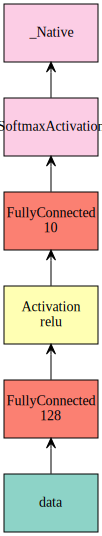

In [94]:
import mxnet as mx
num_classes = 10
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=num_classes)
net = mx.sym.SoftmaxActivation(data=net, name='out');

oldprob_np = mx.sym.Variable('oldprob_np');
act_na = mx.sym.Variable('act_na');
adv_n = mx.sym.Variable('adv_n');
policyloss = PolicyLoss()
policynet = policyloss(prob_np=net, oldprob_np=oldprob_np, act_na=act_na, adv_n=adv_n, name = 'policyloss')

mx.viz.plot_network(policynet)

In [86]:
num_features = 100
batch_size = 100
ex = net.simple_bind(ctx=mx.cpu(), data=(batch_size, num_features))
args = dict(zip(net.list_arguments(), ex.arg_arrays))
for name in args:
    print(name, args[name].shape)

('fc2_weight', (10L, 128L))
('fc1_weight', (128L, 100L))
('out_label', (100L,))
('fc2_bias', (10L,))
('data', (100L, 100L))
('fc1_bias', (128L,))


In [87]:
for name in args:
    data = args[name]
    if 'weight' in name:
        data[:] = mx.random.uniform(-0.1, 0.1, data.shape)
    if 'bias' in name:
        data[:] = 0

In [89]:
adv_n = mx.sym.Variable('adv_n');

In [ ]:
probtype = stochpol.probtype
params = stochpol.trainable_variables
EzFlat.__init__(self, params)

ob_no = stochpol.input
act_na = probtype.sampled_variable()
adv_n = T.vector("adv_n")

# Probability distribution:
prob_np = stochpol.get_output()
oldprob_np = probtype.prob_variable()

logp_n = probtype.loglikelihood(act_na, prob_np)
oldlogp_n = probtype.loglikelihood(act_na, oldprob_np)
N = ob_no.shape[0]

# Policy gradient:
surr = (-1.0 / N) * T.exp(logp_n - oldlogp_n).dot(adv_n)
pg = flatgrad(surr, params)